# Exploratory Analysis of Vehicle-for-Hire Data

This notebook contains an exploratory analysis of vehicle-for-hire app data in New York City.  The data was obtained from the NYC Taxi & Limousine Commission by fivethirtyeight.com via Freedom of Information Act request and posted **[here](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city)**.

The analysis looks at a single month of pick-up data.  Without multi-year data, it was not possible to determine if the upward trend in monthly ride volume was the result of seasonal variation or market expansion.

The analysis is broken up into five sections:

- [Data Prep](#data_prep): Load the data into pandas DataFrame and extract features.
- [Initial Exploration](#initial): Calculate hourly averages for each weekday and plot with seaborn.
- [Spatial Visualization](#spatial): Implement spatial binning and plot with Basemap.
- [Detailed Interactive Plotting](#leaflet): Plot raw data on a Leaflet using mplleaflet.
- [Clustering](#clustering): Cluster data with DBSCAN and plot hot spots on Leaflet.

The heat map was inspired by **[Dotman](https://www.kaggle.com/dotman/data-exploration-and-visualization)**.

The clustering was inspired by **[Geoff Boeing](http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/)**.

#### Package Management

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import mplleaflet as mpl
%matplotlib inline

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

<a id="data_prep"></a>
## Data Prep

Load data into **[pandas](http://pandas.pydata.org/)** DataFrame and get a high level summary.  My data is saved in a directory `./01_data/` which is how I like it.

In [23]:
rides = pd.read_csv('./01_data/uber-raw-data-aug14.csv')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 4 columns):
Date/Time    829275 non-null object
Lat          829275 non-null float64
Lon          829275 non-null float64
Base         829275 non-null object
dtypes: float64(2), object(2)
memory usage: 25.3+ MB


We'll look at the data to gain more intuition.

In [3]:
# rides.head()

If possible, I like to remove special characters and capital letters from the column names.

In [4]:
# rides.columns = ['timestamp', 'lat', 'lon', 'base']

Then we'll convert the "timestamp" entries to pandas Timestamp objects. 

In [5]:
# ti = time.time()

# rides['timestamp'] = pd.to_datetime(rides['timestamp'])

# tf = time.time()
# print(tf-ti,' seconds.')

Goodness! That took a long time.  Let's go ahead and save the data in a convenient format so we can load it to a new/reset kernel without having to convert the timestamp again.

The top line in the cell below will "pickle" the data.  The bottom line will read the `.pkl` file to a pandas DataFrame. 

In [6]:
# rides.to_pickle('./test_data.pkl')
rides = pd.read_pickle('./test_data.pkl')

We *could* try to use the Timestamp objects for the sorting and grouping which is required to make sense of this data set, but it will be much simpler to extract some features up front.  We'll unpack the Timestamp into individual features using datetime methods.  We want the weekday name, the month number, day number, hour number, and minute number all in separate columns.  

We can also use `pandas.Series.dt.strftime` to extract additional features with customized formatting from the timestamp.  It's not necessary for this analysis but I'll demonstrate it below.  For now the lines will be commented out.

In [ ]:
rides['weekday'] = rides.timestamp.dt.weekday_name
rides['month'] = rides.timestamp.dt.month
rides['day'] = rides.timestamp.dt.day
rides['hour'] = rides.timestamp.dt.hour
rides['minute'] = rides.timestamp.dt.minute

## customized features
# rides['month_name'] = rides.timestamp.dt.strftime('%B')
# rides['day_hour'] = rides.timestamp.dt.strftime('%d-%H')

## ocular analysis
rides.head()

Pandas lets us define an ordered categorical index.  We'll choose the weekday; this will help with sorting later on.

In [8]:
day_map = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

rides['weekday'] = pd.Categorical(rides['weekday'], categories=day_map, ordered=True)

<a id="initial"></a>
## Initial Exploration

In this section we'll aggregate the data into more useful metrics.  Specifically, we'll calculate the total number of rides per hour for every hour in the month, and then use that data to calculate the average number of rides for each hour on a given weekday.

#### Hourly Ride Data

We'll count the rides for every hour in the month and retain the weekday feature.  The `groupby` operation will assign a hierarchical index which we can reset.  Also, we'll rename the column to indicate that it's a count of the total number of rides matching the criteria.

In [9]:
## groupby operation
hourly_ride_data = rides.groupby(['day','hour','weekday'])['timestamp'].count()

## reset index
hourly_ride_data = hourly_ride_data.reset_index()

## rename column
hourly_ride_data = hourly_ride_data.rename(columns = {'timestamp':'ride_count'})

## ocular analysis
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Friday,734
1,1,1,Friday,451
2,1,2,Friday,289
3,1,3,Friday,318
4,1,4,Friday,412


#### Weekday Hourly Averages

Next, we'll use the hourly data to compute hourly averages for each weekday.  We'll sort the data on the previously defined weekday index for clean plotting.

In [10]:
## groupby operation
weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean()

## reset index
weekday_hourly_avg = weekday_hourly_avg.reset_index()

## rename column
weekday_hourly_avg = weekday_hourly_avg.rename(columns = {'ride_count':'average_rides'})

## sort by categorical index
weekday_hourly_avg = weekday_hourly_avg.sort_index()

## ocular analysis
weekday_hourly_avg.head()

,weekday,hour,average_rides
0,Monday,0,273.5
1,Monday,1,171.0
2,Monday,2,140.0
3,Monday,3,296.5
4,Monday,4,459.0


#### Define Color Palette

Seaborn's default color blind palette only has six colors, which will cause a repeat for our weekday categorical data. The default color scheme is too bright for my taste, and while you can manually adjust the brightness and saturation in seaborn, it's easy to create colors which are not distinguishable for people with some degree of color blindness when using this approach.

Instead of wasting time hacking together a "functional" color palette, we'll use the *Color Blind 10* from __[Tableau](http://tableaufriction.blogspot.com/2012/11/finally-you-can-use-tableau-data-colors.html)__, with code from __[Randal Olson](http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/)__ to convert from the published 0-255 format to the 0-1 format which matplotlib accepts.

In [11]:
tableau_color_blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

for i in range(len(tableau_color_blind)):  
    r, g, b = tableau_color_blind[i]  
    tableau_color_blind[i] = (r / 255., g / 255., b / 255.)

#### seaborn

The [seaborn](https://seaborn.pydata.org/) package makes visualizing this data quick and convenient.  With a single line of code, we'll plot the average pickup rate vs. hour of the day, for each individual day of the week.  We can conveniently implement our custom *Color Blind 10* color palette and format the plot using familiar matplotlib syntax.

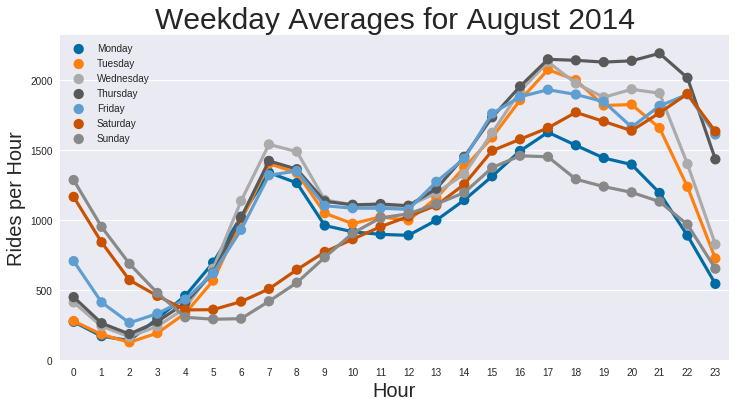

In [12]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='average_rides',hue='weekday', 
              palette = current_palette, data = weekday_hourly_avg)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Weekday Averages for August 2014', fontsize=30)
ax.set_ylabel('Rides per Hour', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

Doesn't that look nice?

Weekdays see a skewed bimodal distribution, with a smaller peak during the morning commute and a larger peak beginning at the close of business and continuing through evening social hours.  Weekends do not experience a morning rush, but rise steadily throughout the day before diverging in the early evening.  Thursday shows the largest evening volume.  However, while Friday and Saturday nights plateau at lower levels than Thursday, the carryover into the early morning party hours (Sat/Sun morning 0-2 AM) is much more significant.

<a id="spatial"></a>
## Spatial Visualization

Can we say anything about the location of these rides?

Let's build a function to help us plot the data on a map.  We'll utilize the **[Basemap](https://matplotlib.org/basemap/)** package to bin the results based on location to create a heat map.  Basemap will use the **[hexbin](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hexbin)** method from matplotlib for the spatial binning.  We'll set the `zorder` parameter so that the heat map is plotted on top of the continent fill.

In [13]:
def heat_map(ax_loc,title_str,rides_this_hour,nsew):
    
    ## get the axis
    ax = fig.add_subplot(ax_loc)

    ## make the basemap object
    m = Basemap(projection='merc', urcrnrlat=nsew[0], llcrnrlat=nsew[1],
                urcrnrlon=nsew[2], llcrnrlon=nsew[3], lat_ts=nsew[1], resolution='f')

    ## draw the background features
    m.drawmapboundary(fill_color = 'xkcd:light blue')
    m.fillcontinents(color='xkcd:grey', zorder = 1)
    m.drawcoastlines()
    m.drawrivers()

    ## project the GPS coordinates onto the x,y representation
    x, y = m(rides_this_hour['lon'].values, rides_this_hour['lat'].values)

    ## count the instances using the hexbin method and plot the results
    m.hexbin(x, y, gridsize=1000, mincnt = 1, bins = 'log', cmap=cm.YlOrRd, zorder = 2);

    ## set the title
    ax.set_title(title_str, fontsize=24)

#### Ask the Question

In the weekday average plot above, we see simlar levels of rides at 5pm and 9pm on Thursday, but are they happening in the same location?  We'll call our `heat_map` function at different times to plot the spatially binned ride distribution on a map.

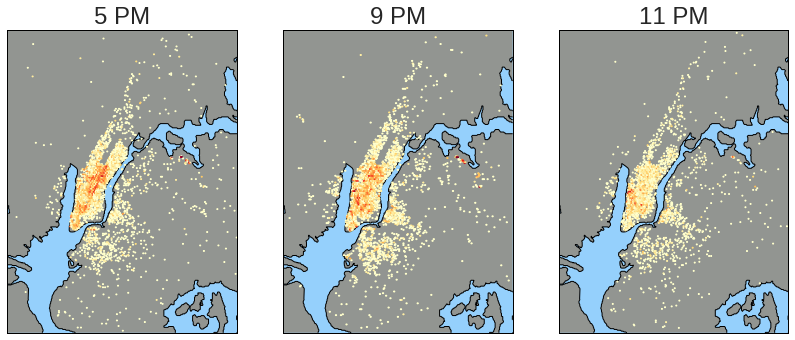

In [14]:
## set weekday for analysis
target_day = 'Thursday'

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9, 40.6, -73.8, -74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## target hours
hrs = [17, 21, 23]

## axis subplot locations
ax_loc = [131, 132, 133] 

## title strings
title_str = ['5 PM', '9 PM', '11 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['weekday'] == target_day) & (rides['hour'] == hrs[ii])]

    ## call hex_loop()
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

First, note that the default shape file included with the Basemap package does not have adequate resolution for this scale.  The Hudson River is not visible, despite calling `drawrivers()`, and Manhatan appears as a peninsula.  We'll need to use a higher resolution shape file for detailed analysis, but we can make some general conclusions based on our knowledge of the city.  Central Park is a highly visible feature which we can use to orient ourselves.

As the workday is ending, the most concentrated traffic is in Midtown, slightly trending towards the Upper East Side.  By 9:00 pm, some of the pressure north of Midtown is relaxing and hot spots are developing in other parts of the city.  They appear close to Greenwich Village and Washington Square Park, with other small hot spots on the Hudson. By 11:00 pm, the total traffic has reduced and there's only one hot spot along the Hudson.

Still, this is average data for all Thursdays in the month.  What if one particular Thursday skewed the results?  

#### Daily Comparison

Luckily, we still have the hourly ride data.

In [15]:
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Friday,734
1,1,1,Friday,451
2,1,2,Friday,289
3,1,3,Friday,318
4,1,4,Friday,412


So we can just grab all of the Thursday hourly data...

In [16]:
thursday_hourly_data = hourly_ride_data[hourly_ride_data['weekday']=='Thursday']

... and plot it with seaborn, color coded by date!

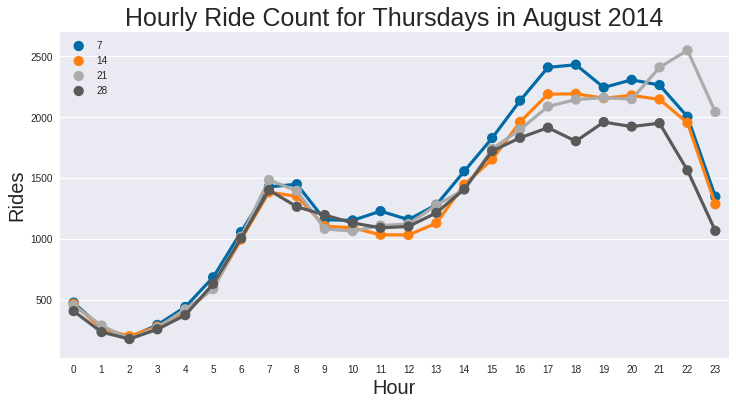

In [17]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day', palette = current_palette, data = thursday_hourly_data)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Hourly Ride Count for Thursdays in August 2014', fontsize=25)
ax.set_ylabel('Rides', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

There is some variation in the evening hours.  Let's compare the highest hourly ride count (10 PM on Aug 21) to the same time on a "typical" Thursday.

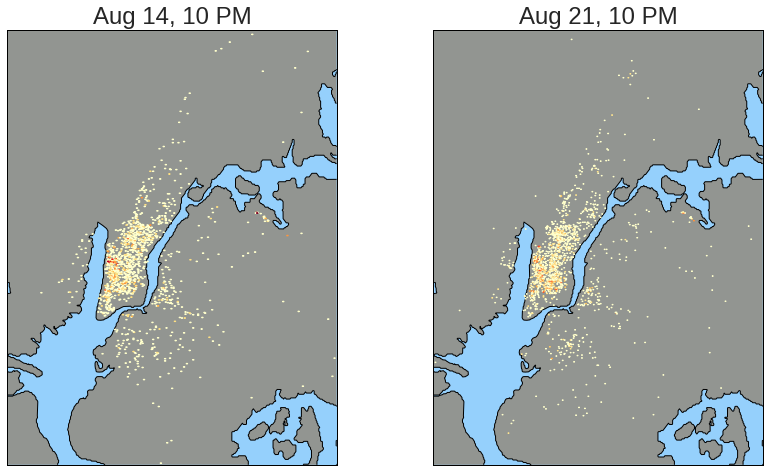

In [18]:
## set day for analysis
target_day = [14, 21]

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9,40.6,-73.8,-74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## hour 
hrs = 22

## axis locations
ax_loc = [121, 122] 

## title strings
title_str = ['Aug 14, 10 PM', 'Aug 21, 10 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['day'] == target_day[ii]) & (rides['hour'] == hrs)]

    ## call hex_loop()
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

These results are ok.  We can see one large cluster on the 14th and several distributed clusters on the 21st, but it's difficult to pinpoint the location.  We really need a more detailed plot to keep asking questions.  One option is to track down the relevant shape files to draw the city in more resolution, but it takes a long time for Basemap to process the data and make the plots anyway.  

<a id="leaflet"></a>
# Detailed Interactive Plotting

We'll utilize **[mplleaflet](https://github.com/jwass/mplleaflet)** to overlay a basic matplotlib plot onto a **[Leaflet](http://leafletjs.com/)**. It will automatically perform the required calculations to project our GPS coordiates onto the 2D representation. It's also significantly faster.

There are two display options for mplleaflet.  You can either open the Leaflet map in a new tab using `mplleaflet.show()`, or you can display the map inline using `mplleaflet.display()`.  The inline display doesn't seem to handle large data sets well, but I have not run into that problem when opening the Leaflet in the new tab.

Go ahead and play around with both options.  You'll note that the marker size does not change as you zoom in. We just have to balance the marker size with the desired map resolution.  If you plan to zoom in a lot, make the marker size bigger.  Luckily, the plotting is very fast and the Leaflet is very responsive so it's not too painful to experiment.

Below I have selected data from Thursday, August 14 between 10:00 PM and 10:15 PM.  You can zoom in, pan around, and see the exact locations of each pickup.

In [22]:
## make the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

## get ride data
rides_this_hour = rides.loc[(rides['day']== 14) & (rides['hour'] == 22) & (rides['minute'] < 16)]

## plot ride data
plt.plot(rides_this_hour['lon'], rides_this_hour['lat'], 'bo', markersize=4)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

<a id="clustering"></a>
# Clustering

While it can be useful to look at the total data set and gain intuition, looking at snap shots doesn't give us enough information to make good conclusions and plotting hours of individual pick-ups just makes a mess.  We want actionable conclusions from this data set, so we'll need to be able to make quantitative comparisons between different regions in the city.  

But how will we define the regions?  

We could manually define them and then bin the pick-ups accordingly, but the information we seek is already in our data set.  Let's just observe how the people move around and look for special cases.

Instead of the spatial binning, we'll implement the **[DBSCAN clustering method from scikit-learn](http://scikit-learn.org/stable/modules/clustering.html#dbscan).  **  This will give us more control over the questions we ask.  It's also much faster than the Basemap implementation of `hexbin`.

The [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) algorithm will group points together that are packed within a specified density metric.  Basically, we'll define a maximum distance to make two individual points count as neighbors, as well as a minimum number of neighbors for a group to qualify as a cluster.  The algorithm will sort the points into groups which meet the criteria and discard all of the outliers.

Once DBSCAN has identified all applicable clusters, we can easily calculate the centroid using the `MultiPoint` class from **[Shapely](https://pypi.python.org/pypi/Shapely)** and plot the results.  

This allows us to precisely identify locations which experience a high volume of pick-ups during a specified time frame.  By using the total number of pickups in an individual cluster as a metric for coloring the hot spot locations, we can visualize the intensity of a given hot spot in addition to it's centroid.

Inspired by **[Geoff Boeing](http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/)**.

#### Clustering Function

First, we'll write a function which runs the clustering algorithm and returns the "hot spots."  We'll get the coordinates of the centroid and the number of pick-ups in each cluster.

In [14]:
def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    coords = ride_data.as_matrix(columns=['lat', 'lon'])
    
    ## calculate epsilon parameter using
    ## the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars,
                algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [lat,lon,num_members]
    
    return hot_spots

#### Ask the Question

Where are the locations which experience more than 25 pickups that occur within 50 meters of each other after 4:00 PM on August 14, 2014?

In [17]:
## get ride data
ride_data = rides.loc[(rides['day']== 21) & (rides['hour'] > 15)]

## maximum distance between two cluster memebers in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 25

## call the get_hot_spots function
hot_spots = get_hot_spots(max_distance ,min_pickups, ride_data)

Number of clusters: 56


Now plot it up!  This time we'll use a scatter plot so that we can set the marker color using the cluster size as a metric. If we use a logarithmic scale on the color map, then there is better visual distinction near the lower bound.  If we use a linear color scale, then values near the lower bound will all appear as a similar color. Go ahead and try them both.

In [26]:
## make the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

## set the color scale
color_scale = np.log(hot_spots[2])
# color_scale = hot_spots[2]

## make the scatter plot
plt.scatter(hot_spots[1], hot_spots[0],s=80,c=color_scale,cmap=cm.cool)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

Now we can easily visualize the 56 locations which experienced at least 25 pick-ups during the hours of 4:00 PM and Midnight on August 21st, 2014. If you were a driver, where would you hang out on a Thursday night?